## <center> **Анализ результатов A/B-тестирования**

Описание кейса: Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. 

Данные: Собранные в результате проведения эксперимента данные находятся в файле ab_data_tourist.csv

Бизнес-задача: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Исследование струтуры данных**

Выводим информацию о типах данных и количестве непустых значений. 
Выясняем, какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Вывод: Пустых значений нет. Столбец date имеет тип данных object.

### **Оценим длительность проведения тестирования для каждой из группы.**

В какой промежуток времени проводился A/B-тест?
Равны ли эти периоды для каждой из групп?

In [352]:
#приводим столбец date к типу данных datetime и нужному формату
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

In [6]:
#группируем данные по признаку группы и определяем первую и последнюю дату наблюдения для каждой из групп
data_group_min = data.groupby(['group'])['date'].min()
data_group_max = data.groupby(['group'])['date'].max()
print(f'Начало периода сбора данных \n{data_group_min}')
print(f'Окончание периода сбора данных \n{data_group_max}')

Начало периода сбора данных 
group
A    2021-01-02
B    2021-01-02
Name: date, dtype: object
Окончание периода сбора данных 
group
A    2021-01-24
B    2021-01-24
Name: date, dtype: object


Вывод: А/В тест проводился в период со 2 по 24 января 2021 в обеих группах.

### **Определим основные показатели**

Количество посещений сайта в группах А и B.
Суммарное количество покупок в группах А и B.
Сумма всех покупок в группах А и B.

In [15]:
#количество посещений сайта в группах А и B
visit_count = data.groupby(['group'])['user_id'].count()
print(f'Количество посещений сайта в группах \n{visit_count}')
#суммарное количество покупок в группах А и B
purchase_count = data.groupby(['group'])['purchase'].sum()
print(f'Cуммарное количество покупок в группах \n{purchase_count}')
#сумма всех покупок в группах А и B
price_count = data.groupby(['group'])['price'].sum()
print(f'Cумма всех покупок в группах(млн.руб) \n{price_count/1000000}')


Количество посещений сайта в группах 
group
A    147202
B    147276
Name: user_id, dtype: int64
Cуммарное количество покупок в группах 
group
A    17723
B    17514
Name: purchase, dtype: int64
Cумма всех покупок в группах(млн.руб) 
group
A    1436.26
B    1554.10
Name: price, dtype: float64


### **Оценим и исключим пересечения данных в группах**

Проверим, есть ли пользователи и сколько, которые в процессе A/B-теста попали в обе тестовые группы? 

In [16]:
mask = data['group'] == 'A'
#создаем множество пользователей группы А
set_a = set(data[mask]['user_id'])
mask1 = data['group'] == 'B'
#cоздаём множество пользователей группы B
set_b = set(data[mask1]['user_id'])
#Пересекаем два этих множества, создаем множество пересечений пользователей групп А и B
set_intersection = set_a.intersection(set_b)
#вычисляем количество элементов в полученном множестве
print(f'Количество уникальных пользователей в группе A: {len(set_a)}')
print(f'Количество уникальных пользователей в группе В: {len(set_b)}')
print(f'Количество пользователей, попавших в обе группы: {len(set_intersection)}')


Количество уникальных пользователей в группе A: 146195
Количество уникальных пользователей в группе В: 146284
Количество пользователей, попавших в обе группы: 1895


In [18]:
#так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей 
updated_data = data[data['user_id'].apply(lambda x: x not in set_intersection)]

In [19]:
#далее мы будем работать только с очищенными от пересечений данными
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


### **Первичный анализ результатов A/B-тестирования**

Для него нам понадобится таблица следующего вида:

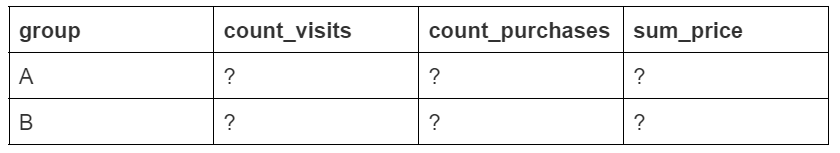

In [20]:
#сгруппируем данные по признаку группы
group_data = updated_data.groupby(['group']).agg({
    #рассчитаем количество посещений (количество пользователей)
    'user_id':'count',
    #рассчитаем количество совершенных покупок
    'purchase':'sum',
    #сумма всех покупок в группе
    'price':'sum'
#в полученной сгруппированной таблице переименуем столбцы
}).reset_index().rename(columns={'user_id': 'count_visits','purchase':'count_purchases','price':'sum_price'})
print(group_data)

  group  count_visits  count_purchases   sum_price
0     A        145307            17487  1417780000
1     B        145381            17290  1533010000


Вывод: Количество посещений обоих вариантов сопоставимо, т.к. отличается на несколько сотых долей процента. 00,05%(145387-145307)/145381*100 
Выборки по количеству сбалансированны.

### **Оценим группы по показателям конверсии и среднему чеку**

- Конверсия покупки - отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах  
- Средний чек - отношение суммы покупок к количеству покупок в каждой группе  

In [21]:
#добавим в таблицу столбец с показателем конверсии
group_data['conversion'] = round((group_data['count_purchases']/group_data['count_visits']*100),2)
#добавим в таблицу столбец со средним чеком
group_data['mean_check'] = round(group_data['sum_price']/group_data['count_purchases'])

In [22]:
group_data.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Ответ: Вариант А более эффективен по абсолютному показателю суммарного количества покупок count_purchases и по относительному показателю конверсии покупки conversion.  
Вариант В более эффективен в абсолюных цифрах по общему количеству посещений сайта count_visits и по сумме покупок sum_price, а также по относительному показателю среднего чека mean_check.

### **Сравним варианты по покупательской способности туров**

In [49]:
#построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура
table = pd.pivot_table(updated_data, values='purchase', index='group', columns='price', aggfunc=np.sum)
print(table)

price  0       10000   60000   100000  150000  200000
group                                                
A           0    5182    5271    1832    3478    1724
B           0    5201    1730    5227    3438    1694


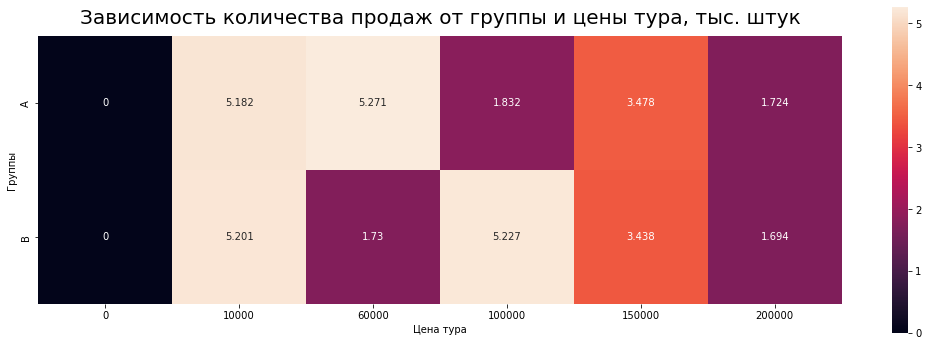

In [52]:
#визуализируем полученную сводную таблицу с помощью тепловой карты с аннотацией
fig, (ax1) = plt.subplots(ncols=1, figsize=(18, 6))
pivot_table = sns.heatmap(table/1000, fmt ='.4g', annot=True, ax=ax1, square=True);
pivot_table.set_title('Зависимость количества продаж от группы и цены тура, тыс. штук', fontdict={'fontsize':20}, pad=12)
pivot_table.set_xlabel("Цена тура");
pivot_table.set_ylabel("Группы");


Вывод: Исходя из построенной таблицы видно, что популярность туров стоимостью 10000, 150000, 200000 руб. в целом одинакова в обоих группах, они окрашены одинаково.  
Имеются различия в популярности туров стоимостью 60000 и 100000 руб. первый более популярен в группе А, а второй в группе В.

### **Cтабилиpуем кумулятивные метрики во времени**

- Ежедневная конверсия = ежедневное количество покупок / ежедневное количество посещений в группе  

- Ежедневный средний чек = ежедневная сумма покупок / ежедневное количество покупок

In [53]:
#построим таблицу с ежедневными данными результатов проведения A/B-тестирования
#сгруппируем данные по дате и группе тестирования
updated_data = updated_data.groupby(['group','date'], as_index=False).agg({
    #в каждой группе вычислим количество посещений страницы
    'user_id':'count',
    #количество покупок
    'purchase':'sum',
    #сумму покупок
    'price':'sum'
}).rename(columns={'user_id': 'count_visits','purchase':'count_purchases','price':'sum_price'})
#добавим в таблицу информацию о ежедневной конверсии в группе
updated_data['day_conv'] = updated_data['count_purchases']/updated_data['count_visits']
#добавим в таблицу информацию о ежедневном среднем чеке в группе
updated_data['day_mean_check'] = updated_data['sum_price']/updated_data['count_purchases']
updated_data.head()

,group,date,count_visits,count_purchases,sum_price,day_conv,day_mean_check
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199


Добавляем в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

При расчете кумулятивной суммы группируем данные по группам. 

In [54]:
# вычисляем кумулятивное количество посещений страницы
updated_data['cum_users_count'] = updated_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок
updated_data['cum_purchase_count'] = updated_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
updated_data['cum_price_count'] = updated_data.groupby(['group'])['sum_price'].cumsum()
display(updated_data.head())

,group,date,count_visits,count_purchases,sum_price,day_conv,day_mean_check,cum_users_count,cum_purchase_count,cum_price_count
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571,2854,359,29410000
1,A,2021-01-03,6596,748,62000000,0.113402,82887.700535,9450,1107,91410000
2,A,2021-01-04,6566,799,64250000,0.121687,80413.016270,16016,1906,155660000
3,A,2021-01-05,6433,790,64550000,0.122804,81708.860759,22449,2696,220210000
4,A,2021-01-06,6606,764,63410000,0.115652,82997.382199,29055,3460,283620000


In [55]:
#вычисляем кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей
#считаем кумулятивную конверсию 
updated_data['cum_conv'] = updated_data['cum_purchase_count']/updated_data['cum_users_count']*100
#считаем кумулятивный средний чек
updated_data['cum_mean_check'] = updated_data['cum_price_count']/updated_data['cum_purchase_count']

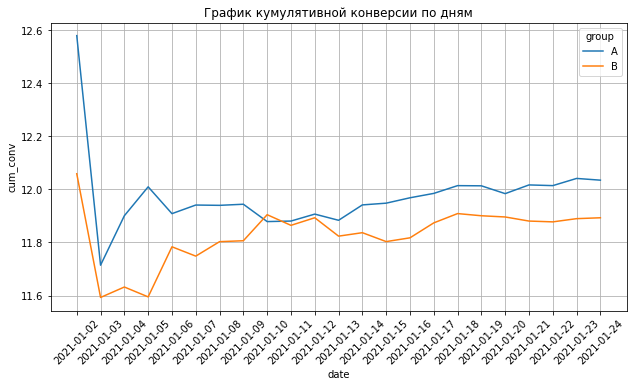

In [59]:
#cтроим кумулятивный график конверсии в каждой группе по дням
#создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
#добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
#строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conv', data=updated_data, hue='group', ax=ax)
#задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
#задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
#задаём отображение сетки
ax.grid(True);

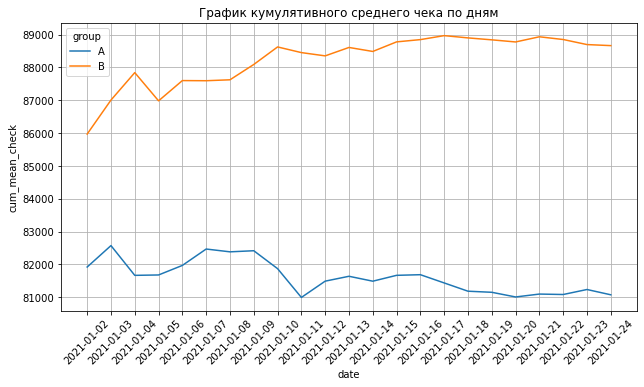

In [58]:
#cтроим кумулятивный график среднего чека в каждой группе по дням
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=updated_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Вывод: А/В тестирование можно считать завершенным, т.к. на графиках прекратились резкие пики и спады показателей, и линии постепенно выравнялись в горизонтальную прямую.   
Кумулятивная конверсия в конце исследования выше в группе А, а показатель кумулятивного среднего чека выше в группе В. 

## **Проверка статистической значимости разницы между метриками**

### **Показатели конверсии в группах**
Для проверки гипотезы о равенстве конверсий в группах применим Z-тест для пропорций.   
Т.к.выборка более 30 элементов, типы переменных количественные и сравниваются 2 группы показателей.

In [60]:
#импортируем библиотеку для z-теста
from statsmodels.stats.proportion import proportions_ztest

In [61]:
# Сгруппируем данные по признаку группы и рассчитаем количество «успехов» 
# (сумма по столбцу converted) и общее количество наблюдений 
# (количество непустых значений в столбце converted) для каждой группы.
converted_piv= data.groupby('group', as_index = False)['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)


,sum,count
group,,
A,17723,147202
B,17514,147276


In [372]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Вывод: По результатам проведенного теста статистической разницы между конверсиями в группах А и В нет.

### **Проверка доверительного интервала для показателей конверсии**
Убедимся в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними.   
Используем $z_{крит}$ в своих расчетах, т.к. размер выборки больше 30 наблюдений

In [373]:
#импортируем библиотеку для расчёта z критического
from scipy.stats import norm
#рассчитаем z критическое
z_crit = -norm.ppf(alpha/2)

In [374]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [377]:
def proportions_conf_interval(n, x_p, gamma=0.95): 
    """Функция вычисляет доверительный интервал

    Args:
        n (int): размер выборки
        x_p (float): выборочная пропорция(долю совершивших конверсию пользователей, то есть выборочная конверсия)
        gamma (float, int):  уровень надёжности (по умолчанию 0.95)

    Returns:
      Кортеж из умноженных на 100 и округлённых до 2 го знака границ доверительного интервала
    """
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [378]:
conf_interval_a = proportions_conf_interval(
n=a_data['count_visits'].sum(), # размер выборки
x_p=a_data['day_conv'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['count_visits'].sum(), # размер выборки
x_p=b_data['day_conv'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.88, 12.21)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


### **Доверительные интервалы разницы конверсий в группах**  

- Проинтерпретируем построенные доверительные интервалы для конверсий в группах.     
- Проанализируем, есть ли перекрытие между доверительными интервалами для групп 
- Проанализируем, есть ли статистическая разница между конверсиями в группах А и B.

In [379]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """Вычисление границ доверительного интервала разницы конверсий

    Args:
        n (list): список из размеров выборки для групп А и B соответственно
        xp (list): список из выборочных пропорций для групп А и B соответственно
        gamma (float, optional): уровень надёжности (по умолчанию он равен 0.95)

    Returns:
        tuple:Кортеж из вычисленных границ доверительного интервала разницы конверсий,
               умноженных на 100 % и округлённых до второго знака после запятой.
    """
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [380]:
# размеры выборок групп А и B
n = [a_data['count_visits'].sum(), b_data['count_visits'].sum()]
# выборочная пропорция групп A и B
xp = [a_data['day_conv'].mean(), b_data['day_conv'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Вывод: Между доверительными интервалами для групп А и В есть есть перекрытие.   
То есть мы не можем однозначно сказать, есть ли статистическая разница в конверсиях.   
Поэтому строим доверительный интервал разницы конверсий.  
Левая граница доверительного интервала отрицательная, а правая — положительная.   
То есть истинная разница в конверсии может быть как положительной, так и отрицательной.   
Тогда это будет значить, что варианты А и B равнозначны по метрике конверсии.  
Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %.   
То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной.   
Мы имеем дело с третьим случаем — интервал охватывает точку 0.  
Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

### **Показатели среднего чека в группах**

## **Оценим нормальность распределения ежедневного среднего чека**

Для проверки гипотезы о нормальности распределения ежедневного среднего чека применим тест Шапиро-Уилка

In [381]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(updated_data[updated_data['group'] == 'A']['day_mean_check'])
shapiro_result_b = shapiro(updated_data[updated_data['group'] == 'B']['day_mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах? 
Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

Ответ: Для проверки гипотезы о равенстве средних чеков по дням в группах применим Т-тест.

In [382]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=updated_data[updated_data['group'] == 'A']['day_mean_check'],
    b=updated_data[updated_data['group'] == 'B']['day_mean_check'], 
    alternative='less' #Левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' 
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Ответ: Исходя из проведенного статистического Т-теста есть статистически значимая разница между ежедневными средними чеками в группах А и B.
Ежедневный средний чек в группе А меньше, чем в группе B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [383]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [384]:
n_a = a_data['count_visits'].count() # размер выборки
k = n_a - 1 # число степеней свободы
x_mean_a = a_data['day_mean_check'].mean() # выборочное среднее
x_std_a = a_data['day_mean_check'].describe()['std'] # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [387]:
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std_a/(n_a ** 0.5) # погрешность
lower_bound = x_mean_a - eps # левая (нижняя) граница
upper_bound = x_mean_a + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал A: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал A: (79630, 82308)


In [389]:
n_b = b_data['count_visits'].count() # размер выборки
k = n_b - 1 # число степеней свободы
x_mean_b = b_data['day_mean_check'].mean() # выборочное среднее
x_std_b = b_data['day_mean_check'].describe()['std'] # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [390]:
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std_b/(n_b ** 0.5) # погрешность
lower_bound = x_mean_b - eps # левая (нижняя) граница
upper_bound = x_mean_b + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Ответ: Между доверительными интервалами для групп А и В нет пересечения.
Отсюда можно сделать вывод, что существует статистическая разница в ежедневном среднем чеке между вариантами А и В.


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Ответ: По метрике среднего чека можно сделать вывод, что вариант дизайна посадочной страницы 'B' более предпочтительный, т.к. существует статистически значимая разница в данном показателе между вариантом А и В.  
По метрике конверсии вывода о предпочтительности того или иного дизайна сделать нельзя, т.к. не существует статистически значимой разницы между вариантами А и В.
